In [1]:
import numpy as np
from numpy import loadtxt
from google.colab import drive
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

KeyboardInterrupt: ignored

LSTM EEG Classifier in Pytorch with random parameter search

In [15]:
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [16]:
def loadData(isLSTMfirstLayer, valPercentage):
  trainX = np.loadtxt("PsiloClassifier/dataSplit/trainX2.csv", delimiter= ",")
  trainY = np.loadtxt("PsiloClassifier/dataSplit/trainY2.csv", delimiter= ",")
  testX = np.loadtxt("PsiloClassifier/dataSplit/testX2.csv", delimiter= ",")
  testY = np.loadtxt("PsiloClassifier/dataSplit/testY2.csv", delimiter= ",")
  valX = np.loadtxt("PsiloClassifier/dataSplit/valX2.csv", delimiter= ",")
  valY = np.loadtxt("PsiloClassifier/dataSplit/valY2.csv", delimiter= ",")
  
  if(isLSTMfirstLayer):
    shape = trainX.shape
    samples = shape[0]
    timesteps = shape[1]
    trainX = trainX.reshape(samples, timesteps, 1)

    shape= testX.shape
    samples = shape[0]
    timesteps = shape[1]
    testX = testX.reshape(samples, timesteps, 1)

    shape= valX.shape
    samples = shape[0]
    timesteps = shape[1]
    valX = valX.reshape(samples, timesteps, 1)

  trainX = trainX.astype('float32')
  testX = testX.astype('float32')
  valX = valX.astype('float32')
  trainY = trainY.astype('float32').reshape((-1,1))
  testY = testY.astype('float32').reshape((-1,1))
  valY = valY.astype('float32').reshape((-1,1))

  trainX = torch.tensor(trainX)
  trainY = torch.tensor(trainY)
  testX = torch.tensor(testX)
  testY = torch.tensor(testY)
  valX = torch.tensor(valX)
  valY = torch.tensor(valY)

  return trainX, trainY, valX, valY, testX, testY

In [17]:
def createDataset(trainX, trainY, valX, valY):
  train_ds = TensorDataset(trainX, trainY)
  val_ds = TensorDataset(valX, valY)
  return train_ds, val_ds

In [18]:
def createDataLoaders(train_ds, val_ds, bs):
  train_dl = DataLoader(train_ds, bs, shuffle=False)
  val_dl = DataLoader(val_ds, bs, shuffle=False)
  return train_dl, val_dl

In [19]:
sigmoid = nn.Sigmoid()
criterion = nn.BCELoss()

class LSTMClassifier(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_lstm_layers, output_dim):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_lstm_layers = num_lstm_layers
    self.rnn = nn.LSTM(input_dim, hidden_dim, num_lstm_layers, batch_first=True)
    self.fc1 = nn.Linear(hidden_dim, 16)
    self.fc = nn.Linear(16, output_dim)

  def forward(self, x):
    h0, c0 = self.init_hidden(x)
    out, (hn, cn) = self.rnn(x, (h0, c0))
    out = self.fc1(out[:, -1, :])
    out = self.fc(out)
    out = sigmoid(out)
    return out

  def init_hidden(self, x):
    h0 = torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_dim).to(device)
    c0 = torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_dim).to(device)
    return h0, c0

def accuracyAndLoss(data_loader, model):
  total, correct, loss, batches = 0, 0, 0, 0
  model.eval()
  for x, y in data_loader:
    x = x.to(device)
    y = y.to(device)
    out = model(x)
    preds = out.round()
    total += y.size(0)
    batches += 1
    correct += (preds == y).sum().item()
    loss += criterion(out, y)
  return correct/total, loss/batches

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainX, trainY, valX, valY, testX, testY = loadData(True, 20)
train_ds, val_ds = createDataset(trainX, trainY, valX, valY)
train_dl, val_dl = createDataLoaders(train_ds, val_ds, bs=512)

In [48]:
def train_model(lr, epochs, hidden_dim, num_lstm_layers, plot=False):
  
  model = LSTMClassifier(1, hidden_dim, num_lstm_layers, 1).to(device)
  criterion = nn.BCELoss()
  opt = torch.optim.RMSprop(model.parameters(), lr=lr)
  
  train_accuracy = []
  val_accuracy = []
  train_loss = []
  val_loss = []

  print('Starting model training... lr:', lr, ' epochs:', epochs,  ' hidden_dim:', hidden_dim, ' num_lstm_layers:', num_lstm_layers)
  for epoch in range(epochs):
      for i, (x_batch, y_batch) in enumerate(train_dl):
          model.train()
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          opt.zero_grad()
          out = model(x_batch)
          loss = criterion(out, y_batch)
          loss.backward()
          opt.step()
      
      with torch.no_grad():
          train_accuracy_, train_loss_ = accuracyAndLoss(train_dl, model)
          train_accuracy.append(train_accuracy_)
          train_loss.append(train_loss_)
          val_accuracy_, val_loss_ = accuracyAndLoss(val_dl, model)
          val_accuracy.append(val_accuracy_)
          val_loss.append(val_loss_)
          
      print('Epoch ' , epoch , '... train_accuracy:', round(train_accuracy[-1], 3), ' val_accuracy:', round(val_accuracy[-1], 3), ' train_loss:', round(train_loss[-1].item(), 3), ' val_loss:', round(val_loss[-1].item(), 3) )

  if plot == True: 
    plt.subplot(2,1,1)
    plt.plot(train_accuracy, 'b')
    plt.title("accuracy")
    plt.plot(val_accuracy, 'r')

    plt.subplot(2,1,2)
    plt.plot(train_loss, 'b')
    plt.title("loss")
    plt.plot(val_loss, 'r')

    plt.tight_layout()
    plt.show()

  print('Training complete! train_accuracy:', round(train_accuracy[-1], 3), ' val_accuracy:', round(val_accuracy[-1], 3), ' train_loss:', round(train_loss[-1].item(), 3), ' val_loss:', round(val_loss[-1].item(), 3) )

  return train_accuracy, val_accuracy, train_loss, val_loss, model;

In [11]:
#stores all information relevant to a model trained using random parameter search
class trainedModel:
  def __init__(self, lr, epochs, hidden_dim, num_lstm_layers, train_accuracy, val_accuracy, train_loss, val_loss):
    self.lr = lr
    self.epochs = epochs
    self.hidden_dim = hidden_dim
    self.num_lstm_layers = num_lstm_layers
    self.train_accuracy = train_accuracy
    self.val_accuracy = val_accuracy
    self.train_loss = train_loss
    self.val_loss = val_loss
    self.final_val_accuracy = val_accuracy[-1]

  def __gt__(self, other):
    return self.final_val_accuracy > other.final_val_accuracy

#searches for optimal parameters within intervals of lr, epoch, etc. using uniform distribution. keeps and returns top 10 model objects (not their parameters, just their hyperparameters)
def paramSearch(reps, lr_min, lr_max, epoch_min, epoch_max, hidden_dim_min, hidden_dim_max, num_lstm_min, num_lstm_max):
  num_models_to_keep = 10
  best_trained_models = []

  for rep in range(reps):
    lr = np.random.uniform(lr_min, lr_max)
    epochs = int(np.random.uniform(epoch_min, epoch_max))
    hidden_dim = int(np.random.uniform(hidden_dim_min, hidden_dim_max))
    num_lstm_layers = int(np.random.uniform(num_lstm_min, num_lstm_max))

    train_accuracy, val_accuracy, train_loss, val_loss, model = train_model(lr, epochs, hidden_dim, num_lstm_layers)
    trained_model = trainedModel(lr, epochs, hidden_dim, num_lstm_layers, train_accuracy, val_accuracy, train_loss, val_accuracy)

    if len(best_trained_models) < num_models_to_keep: 
      best_trained_models.append(trained_model)
      best_trained_models.sort(key=lambda x: x.final_val_accuracy, reverse=True)
    else:
      if trained_model > best_trained_models[num_models_to_keep - 1]:
        best_trained_models[num_models_to_keep - 1] = trained_model
        best_trained_models.sort(key=lambda x: x.final_val_accuracy, reverse=True)

  for i, x in enumerate(best_trained_models):
    print(i,': ' , x.final_val_accuracy, ' lr: ', x.lr, ' epochs:', x.epochs, ' hidden_dim:', x.hidden_dim, ' num_layers:', x.num_lstm_layers)
  return best_trained_models

In [ ]:
x = []
x = paramSearch(10, 0.001, 0.02, 1, 10, 1, 100, 1, 6)

In [ ]:
a, b, c, d, model = train_model(0.0034, 10, 71, 1, True)

Starting model training... lr: 0.0034  epochs: 10  hidden_dim: 71  num_lstm_layers: 1
torch.Size([512, 250, 71])


Starting model training... lr: 0.001  epochs: 150  hidden_dim: 100  num_lstm_layers: 1
Epoch  0 ... train_accuracy: 0.508  val_accuracy: 0.492  train_loss: 0.693  val_loss: 0.694
Epoch  1 ... train_accuracy: 0.519  val_accuracy: 0.491  train_loss: 0.69  val_loss: 0.695
Epoch  2 ... train_accuracy: 0.505  val_accuracy: 0.496  train_loss: 0.693  val_loss: 0.695
Epoch  3 ... train_accuracy: 0.514  val_accuracy: 0.491  train_loss: 0.693  val_loss: 0.695
Epoch  4 ... train_accuracy: 0.509  val_accuracy: 0.503  train_loss: 0.693  val_loss: 0.698
Epoch  5 ... train_accuracy: 0.626  val_accuracy: 0.565  train_loss: 0.639  val_loss: 0.689
Epoch  6 ... train_accuracy: 0.648  val_accuracy: 0.56  train_loss: 0.622  val_loss: 0.734
Epoch  7 ... train_accuracy: 0.656  val_accuracy: 0.57  train_loss: 0.611  val_loss: 0.721
Epoch  8 ... train_accuracy: 0.663  val_accuracy: 0.577  train_loss: 0.605  val_loss: 0.718
Epoch  9 ... train_accuracy: 0.667  val_accuracy: 0.586  train_loss: 0.6  val_loss: 0.70

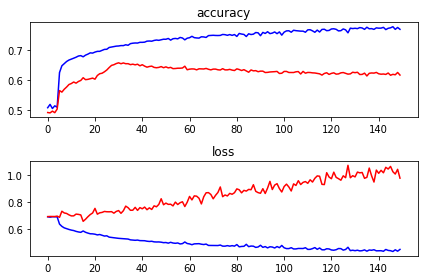

Training complete! train_accuracy: 0.77  val_accuracy: 0.617  train_loss: 0.452  val_loss: 0.978


In [51]:
a, b, c, d, model = train_model(0.001, 150, 100, 1, True)